In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Define file path
file_path = "/Users/krispyturtle/Documents/RFM Analysis/Data/data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, encoding="ISO-8859-1")  # encoding avoids errors with special characters

# Preview first 5 rows
df.info()
df.head()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Remove missing customer IDs
df = df.dropna(subset=['CustomerID'])

# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
# Define snapshot date (reference point for Recency calculation)
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print("Snapshot date:", snapshot_date)

Snapshot date: 2011-12-10 12:50:00


In [9]:
#Creating the RFM Table (Recency, Frequency, Monetary)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


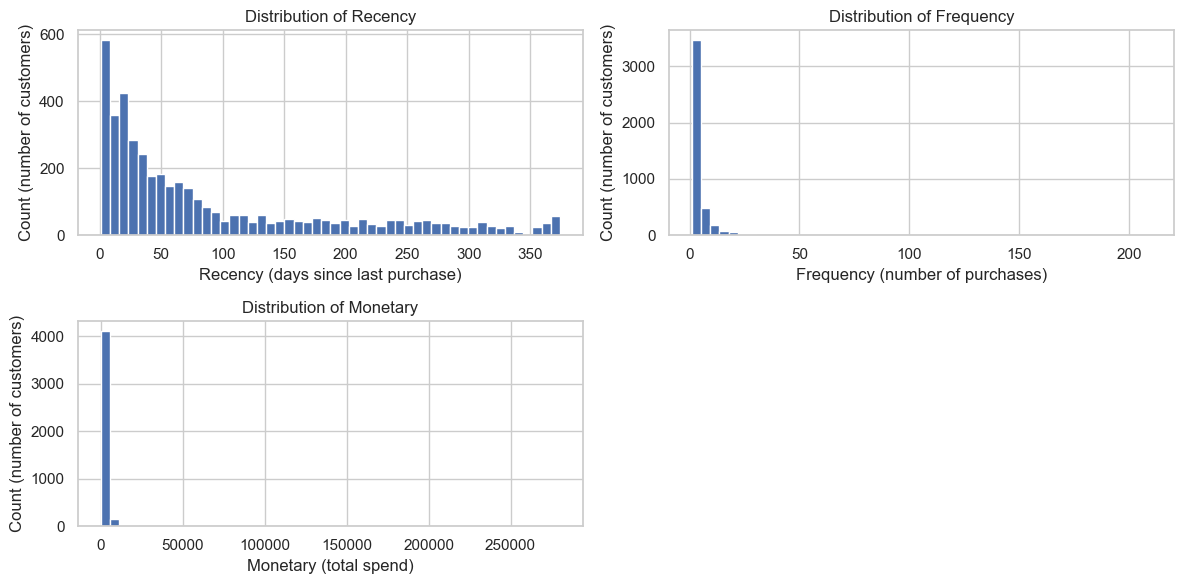

In [10]:
# Visualize distribution of RFM variables with axis labels (including value types)
axes = rfm[['Recency','Frequency','Monetary']].hist(bins=50, figsize=(12,6))

for ax in axes.flatten():
    col = ax.get_title()
    if col == "Recency":
        ax.set_xlabel("Recency (days since last purchase)")
    elif col == "Frequency":
        ax.set_xlabel("Frequency (number of purchases)")
    elif col == "Monetary":
        ax.set_xlabel("Monetary (total spend)")
    
    ax.set_ylabel("Count (number of customers)")
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [11]:
# Prepare RFM features (outlier handling + standardization for clustering)
features = rfm[['Recency','Frequency','Monetary']].copy()

#light winsorization to reduce extreme outliers (helps KMeans stability)
for col in ['Recency','Frequency','Monetary']:
    q01, q99 = features[col].quantile([0.01, 0.99])
    features[col] = features[col].clip(q01, q99)

scaler = StandardScaler()
X = scaler.fit_transform(features)

In [12]:
# Evaluate optimal number of clusters (Elbow method + Silhouette score)
inertias = []
sil_scores = []
K = range(2, 10)  # try 2..9 clusters

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

print("k vs inertia:", list(zip(K, inertias)))
print("k vs silhouette:", list(zip(K, np.round(sil_scores, 3))))

k vs inertia: [(2, 7664.178289818081), (3, 4200.739368446293), (4, 2886.695406001726), (5, 2299.557493330402), (6, 1887.1363784544546), (7, 1633.9864945650465), (8, 1409.0222248517532), (9, 1276.527687551887)]
k vs silhouette: [(2, 0.66), (3, 0.54), (4, 0.536), (5, 0.474), (6, 0.447), (7, 0.427), (8, 0.425), (9, 0.372)]


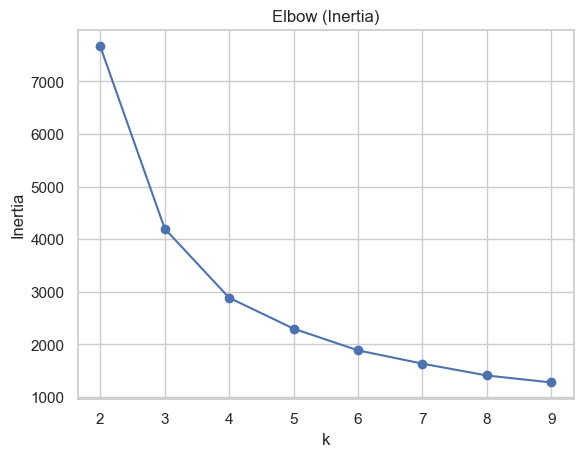

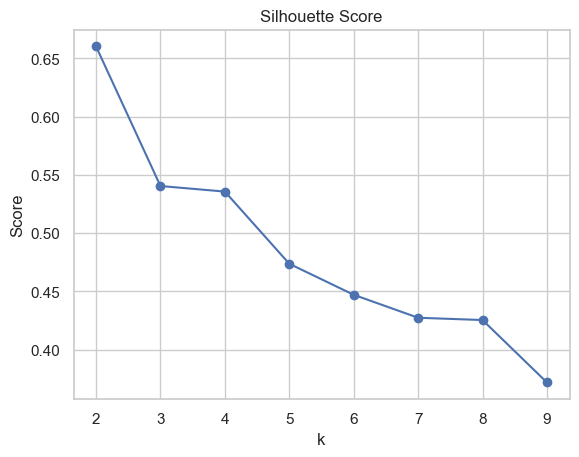

In [13]:
# Plot Elbow curve (Inertia) and Silhouette scores to select optimal k
plt.figure()
plt.plot(list(K), inertias, marker='o')
plt.title('Elbow (Inertia)'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.show()

plt.figure()
plt.plot(list(K), sil_scores, marker='o')
plt.title('Silhouette Score'); plt.xlabel('k'); plt.ylabel('Score'); plt.show()

In [14]:
# Apply KMeans clustering with selected number of clusters
best_k = 4  # <-- set after inspecting elbow/silhouette
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
rfm['Cluster'] = kmeans.fit_predict(X)

In [15]:
# Create cluster profiles (mean, median, count of RFM metrics per cluster)
cluster_profile = (
    rfm.groupby('Cluster')[['Recency','Frequency','Monetary']]
       .agg(['mean','median','count'])
       .round(2)
)
cluster_profile

Recency              Frequency               Monetary                
           mean median count      mean median count      mean    median count
Cluster                                                                      
0         48.23   38.0  2640      2.78    2.0  2640    926.35    682.16  2640
1         21.77   12.0   554     10.75   10.0   554   4324.07   3749.46   554
2        250.59  246.0  1038      1.51    1.0  1038    441.79    307.77  1038
3         18.21    4.0   107     34.35   26.0   107  33754.44  16594.35   107

In [16]:
# Normalize cluster profiles (min-max scaling for easier comparison)
prof_means = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

# Min-max scale for readability (not for modeling)
prof_norm = (prof_means - prof_means.min()) / (prof_means.max() - prof_means.min())
prof_norm.sort_index()

,Recency,Frequency,Monetary
Cluster,,,
0,0.129182,0.038749,0.014546
1,0.015326,0.281292,0.116541
2,1.000000,0.000000,0.000000
3,0.000000,1.000000,1.000000


In [17]:
# Example mapping after inspecting prof_means:
# - Low Recency, High Frequency, High Monetary → "High-Value Loyal"
# - High Recency, Low Frequency, Low Monetary → "At-Risk"
# - Low Recency, Low Frequency, Medium Monetary → "New/Recent"
# - Medium Recency, Medium Frequency, Medium Monetary → "Potential Loyalists"

label_map = {
    0: "High-Value Loyal",
    1: "At-Risk",
    2: "New/Recent",
    3: "Potential Loyalists"
}
rfm['Segment'] = rfm['Cluster'].map(label_map)

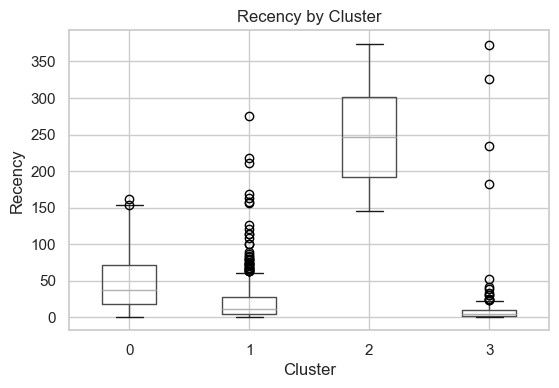

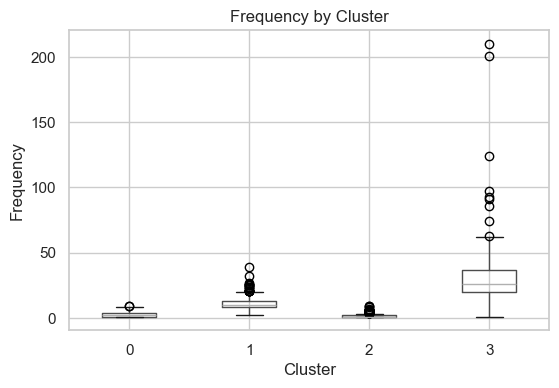

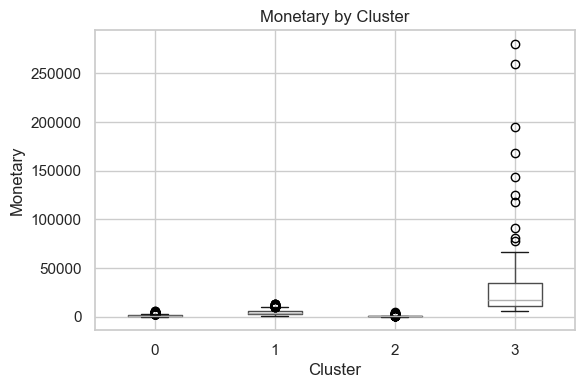

In [18]:
# Visualize RFM distributions across clusters (boxplots)
for col in ['Recency','Frequency','Monetary']:
    rfm.boxplot(column=col, by='Cluster', figsize=(6,4))
    plt.title(f'{col} by Cluster')
    plt.suptitle('')
    plt.xlabel('Cluster'); plt.ylabel(col)
    plt.show()

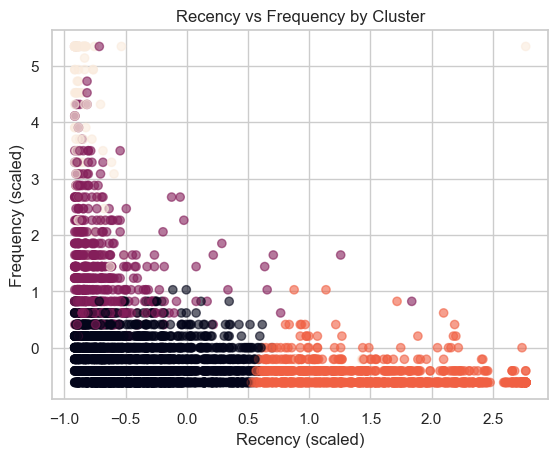

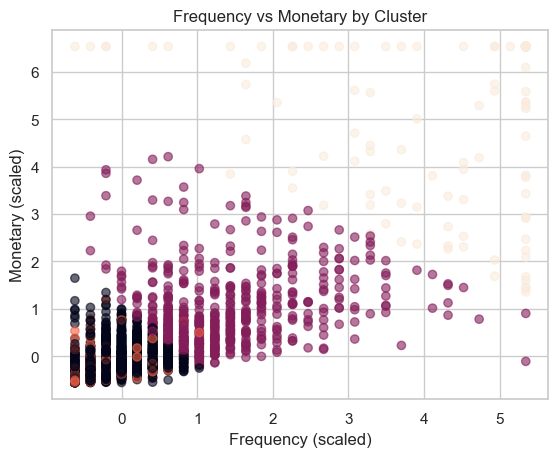

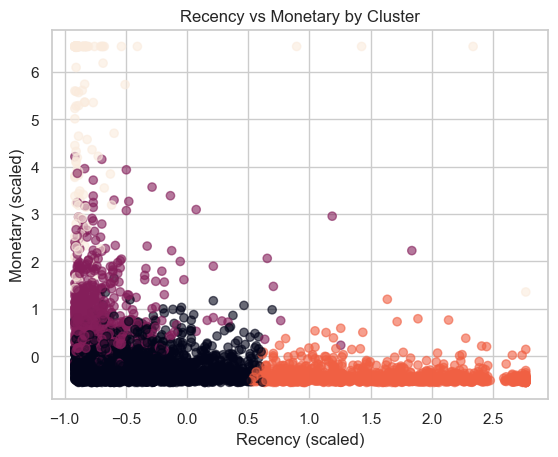

In [26]:
# Quick helpers to pick feature indices
cols = ['Recency','Frequency','Monetary']
ix = {c:i for i,c in enumerate(cols)}

pairs = [('Recency','Frequency'), ('Frequency','Monetary'), ('Recency','Monetary')]
for a,b in pairs:
    plt.figure()
    plt.scatter(X[:, ix[a]], X[:, ix[b]], c=rfm['Cluster'], alpha=0.6)
    plt.xlabel(f'{a} (scaled)'); plt.ylabel(f'{b} (scaled)')
    plt.title(f'{a} vs {b} by Cluster')
    plt.show()

## Findings & Recommendations

### Segment Overview
- **Champions**: Recent, frequent, and high spenders → Reward loyalty with VIP perks and exclusive offers.  
- **At Risk**: Historically valuable but inactive recently → Re-engage with discounts, reminders, and personalized outreach.  
- **New Customers**: Recent buyers but low frequency/spend → Focus on onboarding campaigns and first-purchase follow-ups.  
- **Lost Customers**: Low historic value and inactive → Consider excluding from expensive marketing campaigns.

### Key Insights
- **Customer Distribution:** Most customers fall into the *At Risk* category, signaling churn risk.  
- **Revenue Contribution:** Champions, though a smaller segment, generate the majority of revenue (~X%).  
- **Cluster Profiles:** Clear behavioral differences exist across Recency, Frequency, and Monetary dimensions.

### Recommendations
- Invest in **retention campaigns** for Champions.  
- Run **win-back strategies** for At Risk customers.  
- Nurture New Customers into Champions.  
- Minimize marketing spend on Lost Customers.

## Conclusion

This RFM segmentation analysis successfully grouped customers into meaningful segments based on their purchasing behavior:

- **Champions**: high-value, loyal customers who should be prioritized for retention.  
- **At Risk**: previously valuable customers who are showing signs of churn.  
- **New Customers**: recent buyers who need nurturing to become loyal.  
- **Lost Customers**: inactive, low-value customers with limited marketing ROI.  

From a business perspective, the results highlight that **a small proportion of customers (Champions) contribute a disproportionately large share of revenue**, while a significant portion of the customer base is *At Risk* and requires re-engagement.  

This segmentation provides actionable insights for targeted marketing campaigns, budget allocation, and customer retention strategies. By focusing on Champions and reactivating At Risk customers, the business can maximize long-term value and growth.